In [1]:
#importing our required libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
import gensim
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelBinarizer

In [2]:
DB_CONNECT = sqlite3.connect('database.sqlite') 
REVIEW_FILTERED = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """,DB_CONNECT)
# here, we are omitting reviews =3 and then returning new dataframe into REVIEW_FILTERED
def polarity(rev):
    if rev<3:
        return 'negative'
    return 'positive'
actualScore=REVIEW_FILTERED['Score'] #score column is copied to actual score
positiveNegative=actualScore.map(polarity)# mapping the column to polarity method and returning strings(positive,negative) 
REVIEW_FILTERED['Score']=positiveNegative # replacing the columns in our data with positive/negative strings
print(REVIEW_FILTERED.shape) #looking at the number of attributes and size of the data
REVIEW_FILTERED.head(2)

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


#                               TEXT-PRE PROCESSING PHASE

In [3]:
#remove duplicate rows as we have duplicate product id with similar other data
rem_dup=REVIEW_FILTERED.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")
rem_dup.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
print(REVIEW_FILTERED.shape)
print(rem_dup.shape)

(525814, 10)
(364173, 10)


after removing duplicates , we have reduced the no .of rows from 525814 to 364173

In [5]:
# Take out the rows with heplful_num>helpful_den. As W've observed two rows in previous case
df1=rem_dup[rem_dup.HelpfulnessNumerator<=rem_dup.HelpfulnessDenominator]
df1.shape

(364171, 10)

In [6]:
#It's better to sample our data upto 50k points as our dataset is huge
sample_data=5000
df1=df1.sample(sample_data)
df1.sort_values('Time',inplace=True) #Sorting as we want according to time series
df1.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
212494,230308,B00004RYGX,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,positive,1014681600,...,"It was on the other night, and, having been a ..."
156021,169214,B0001ES9FI,A2WE1DWPQRDBFW,Scotbuff,6,6,positive,1088035200,Full Bodied and Never Burnt,The Dark Roast is the best of the coffee pods ...
212527,230342,B00004RYGX,A19JYLHD94K94D,Itamar Katz,2,2,positive,1089244800,Remains one of my favorites,Re-watching Beetlejuice more than a decade aft...


In [7]:
nltk.download('stopwords')
#pre-process each and every text review 
'''Function for HTML-Tag removal
 we are creating function which removes HTML scripts that present in our text reviews'''
def rem_html_tags(review):
    text=re.compile('<.*?>')# regular expressions that need to be find
    return text.sub('',review) #replace nothing while above tags occur
#Function for Punctuation marks removal
def rem_punctuations(review):
    text=re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return text.sub('',review)
#Now, Intialise stop-words(most-common words which makes of no-value while vectoring)
stop_words=set(stopwords.words('english')) #these are set of stopwords
#Intialise snow-ball stemmer
snow_stem=nltk.stem.SnowballStemmer('english') #returns root of some words
from time import time
%time
count=0 # intializing counter for iterating through entire rows
str1=''
final_str=[]
pos_words=[] #stores words from positive reviews
neg_words=[] #stores words from negative reviews
str2=''
t0=time()
for sentence in df1['Text'].values: # Iterate through all reviews
  filtered_sentence=[] # creating a list which we append filtered words later
  html_filtered=rem_html_tags(sentence) # returns HTML-filtered format
  punct_filtered=rem_punctuations(html_filtered) # returns words with no-puctuation marks
  half_filtered=punct_filtered.split() # contains words without HTML & punctuation marks
  for word in half_filtered: # iterate through each word in review
    if(word.isalpha() and len(word)>2): # checking whether all characters are alphabets and limiting length
      if(word.lower() not in stop_words):
        str2=(snow_stem.stem(word.lower())).encode('utf8') # stemming each and every word
        filtered_sentence.append(str2) # updating our list with stemmed words
        if (df1['Score'].values)[count]=='positive': 
          pos_words.append(str2) #list of all words used to describe positive reviews
        if(df1['Score'].values)[count]=='negative':
          neg_words.append(str2) #list of all words used to describe negative reviews reviews
      else:
        continue
    else:
      continue
  str1 = b" ".join(filtered_sentence) #final string of cleaned words
  final_str.append(str1)
  count+=1
print("text successfully pre-processed")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kprk_25/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs
text successfully pre-processed


In [8]:
df1['CleanedText']=final_str # adding new column to df1 by adding our filtered reviews
df1['CleanedText']=df1['CleanedText'].str.decode("utf-8") # standard decoding format
df1.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
212494,230308,B00004RYGX,A3C3BAQDZWH5YE,Kushana no shinryaku (Kushana's invasion),0,1,positive,1014681600,...,"It was on the other night, and, having been a ...",night big fan cartoon shown decid watch also t...
156021,169214,B0001ES9FI,A2WE1DWPQRDBFW,Scotbuff,6,6,positive,1088035200,Full Bodied and Never Burnt,The Dark Roast is the best of the coffee pods ...,dark roast best coffe pod avail senseo coffe m...


we've added extra column "CleanedText" with pre-processed review

# BAG - OF - WORDS VECTORIZATION

In [9]:
X_train,X_test,y_train,y_test = train_test_split(df1['CleanedText'].values,df1['Score'].values,test_size=0.3,shuffle=False) # splitting into test and train
# we are not using random state because we've already split  based on time
c_vector=CountVectorizer() # intialising bow vectorizer
X_train=c_vector.fit_transform(X_train) # feature extraction of X_train
X_train=preprocessing.normalize(X_train) # normalise data
print("Train Data Size: ",X_train.shape)
X_test=c_vector.transform(X_test) # feature extraction of X_test
X_test=preprocessing.normalize(X_test) # normalise data
print("Test Data Size: ",X_test.shape)

Train Data Size:  (3500, 10650)
Test Data Size:  (1500, 10650)


we've successfully split data into 70:30 ratio between train and test datasets

In [10]:
# FINDING BEST K VALUE WITHOUT BRUTE-FORCE OR KD-TREE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
'''Now , it is required to perform cross-validation for getting the optimized k-value
firstly, we would go through simple cross-validation on our dataset (cross-val on train data without split)'''
# split the train data set into cross validation train and cross validation test
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train, y_train, test_size=0.3,shuffle=False)
k_list=[]
acc_list=[]
for i in range(1,50,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)
    k_list.append(i)
    # fitting the model on crossvalidation train
    knn.fit(X_tr, y_tr)
    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    acc_list.append(acc)
knn = KNeighborsClassifier(1)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)

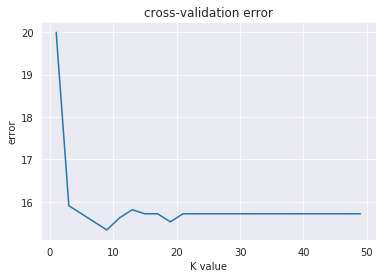

minimum error 15.333333333333329 occurs at k = 9


In [11]:
err=[]
for i in acc_list:
  err.append(100-i)
sns.set_style("darkgrid")
plt.plot(np.arange(1,50,2),err)
plt.xlabel("K value")
plt.ylabel("error")
plt.title("cross-validation error")
plt.show()
print("minimum error",min(err),'occurs at k =',k_list[acc_list.index(max(acc_list))])


# Brute-force function

optimal k : {'n_neighbors': 11}  with accuracy : 84.69982847341338

list of accuracies : [79.7941681  83.87650086 84.21955403 84.63121784 84.59691252 84.69982847
 84.69982847 84.5626072  84.63121784 84.52830189 84.45969125 84.49399657
 84.45969125 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


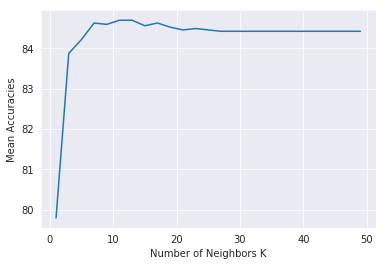

time taken: 22.339608192443848 seconds


In [12]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import time
start_time = time.time()
def func_bruteforce(XTRAIN,YTRAIN):
    knn=KNeighborsClassifier(algorithm='brute')#since, we are using bruteforce algorithm
    grid={'n_neighbors':np.arange(1,50,2)}#creating a dictionary with values as range of K-values
    splits=TimeSeriesSplit(n_splits=5)#time series split of train data using 10-fold cross-validation
    grid_search=GridSearchCV(estimator=knn,param_grid=grid,cv=splits,return_train_score=1,n_jobs=-1) #this actually performs grid search over our grid-values as cv value=10
    grid_search.fit(XTRAIN,YTRAIN)
#     print(grid_search.cv_results_['mean_test_score'])
    return grid_search.best_params_,grid_search.best_score_*100,grid_search.cv_results_['mean_test_score']*100# best_params_ and best_score_ are attributes that returns best k-value and accuracy
optimal_k,accuracy,acc_scores=func_bruteforce(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## Test-accuracy function

In [13]:
# NOW, COMPUTE THE TEST-ACCURACY
# instantiate learning model k = optimal_k
def test_acc(optimal_k,XTRAIN,XTEST):
  knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k)
  # fitting the model
  knn_optimal.fit(XTRAIN, y_train)
  # predict the response
  pred=knn_optimal.predict(XTEST)
  # evaluate accuracy
  acc = accuracy_score(y_test, pred) * 100
  return optimal_k,acc,pred
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 83.733333%


## confusion-matrix function

accuracy we got: 83.73333333333333
precision value : 0.8379287155346334
recall : 0.9975980784627703
F1-SCORE : 0.9108187134502924
     [TN       FP] 
      [FN      TP]


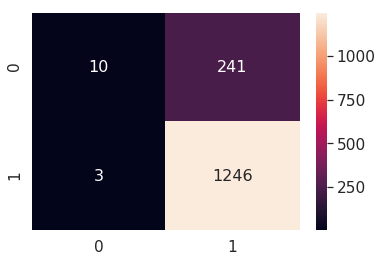

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelBinarizer
def filter(y_test):
  lst=[]
  for x in y_test: # as confusion matrices need only no of positives(1) and negatives(0) in the form of binary digits, we convert lables to +1 or 0
    if x=='positive':
      lst.append(1)
    else:
      lst.append(0)
  return lst
def confuse_matrix(optimal_k,pred,y_test):
    y_con_test=filter(y_test)
    y_con_pred=filter(pred)
    accuracy=accuracy_score(y_con_test,y_con_pred)*100
    print('accuracy we got:' , accuracy)
    precision=precision_score(y_con_test,y_con_pred)
    print('precision value :', precision)
    recall=recall_score(y_con_test,y_con_pred)
    print('recall :',recall)
    F1=f1_score(y_con_test,y_con_pred)
    print('F1-SCORE :',F1)
    conf=pd.DataFrame(confusion_matrix(y_con_test,y_con_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(conf, annot=True,annot_kws={"size": 16}, fmt='g') # y-axis-actual,x-axis-predicted
    print("     [TN       FP] \n      [FN      TP]")
    return None 
confuse_matrix(optimal_k,pred,y_test)


## truncated-svd function

In [15]:
# for K-D tree, we should pass dence matrice to algorithm, hence, we use Truncated SVD
def TSVD(XTRAIN,XTEST):
  standardized_train = StandardScaler(with_mean=False).fit_transform(XTRAIN) # data standardization
  standardized_test = StandardScaler(with_mean=False).fit_transform(XTEST)
#   standardized_train.shape
  tsvd_train = TruncatedSVD(n_components=400, random_state=None).fit_transform(standardized_train)
#   tsvd_train.shape
  tsvd_test = TruncatedSVD(n_components=400, random_state=None).fit_transform(standardized_test)
#   tsvd_test.shape
  return tsvd_train,tsvd_test
# print(TSVD(X_train,X_test))

## KD-Tree Function

optimal k : {'n_neighbors': 7}  with accuracy : 84.76843910806176

list of accuracies : [80.24013722 83.87650086 84.69982847 84.76843911 84.52830189 84.63121784
 84.5626072  84.45969125 84.45969125 84.45969125 84.45969125 84.45969125
 84.45969125 84.45969125 84.45969125 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


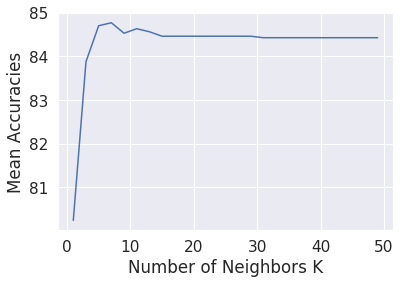

time taken: 350.0651557445526 seconds


In [16]:
start_time = time.time()
def func_kdtree(XTRAIN,YTRAIN):
    knn=KNeighborsClassifier(algorithm='kd_tree')#since, we are using bruteforce algorithm
    grid={'n_neighbors':np.arange(1,50,2)}#creating a dictionary with values as range of K-values
    splits=TimeSeriesSplit(n_splits=5)#time series split of train data using 10-fold cross-validation
    grid_search=GridSearchCV(estimator=knn,param_grid=grid,cv=splits,return_train_score=1,n_jobs=-1) #this actually performs grid search over our grid-values as cv value=10
    grid_search.fit(XTRAIN,YTRAIN)
#     print(grid_search.cv_results_['mean_test_score'])
    return grid_search.best_params_,grid_search.best_score_*100,grid_search.cv_results_['mean_test_score']*100# best_params_ and best_score_ are attributes that returns best k-value and accuracy
train_svd,test_svd=TSVD(X_train,X_test) # passing our vectorized array to TSVD function
optimal_k,accuracy,acc_scores=func_kdtree(train_svd,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-accuracy(kd-tree)

In [17]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],train_svd,test_svd)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 82.933333%


## confusion-matrix(kd-tree)

accuracy we got: 82.93333333333334
precision value : 0.8329979879275654
recall : 0.9943955164131305
F1-SCORE : 0.9065693430656934
     [TN       FP] 
      [FN      TP]
None


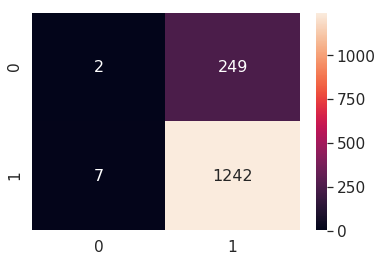

In [18]:
print(confuse_matrix(optimal_k,pred,y_test))

# TF-IDF Vectorization

In [19]:
X_train,X_test,y_train,y_test = train_test_split(df1['CleanedText'].values,df1['Score'].values,test_size=0.3,shuffle=False) #shuffle=false because we've done time-based split
tfidf=TfidfVectorizer()# intializing vectorizer
X_train=tfidf.fit_transform(X_train) # fitting our model to tfidf
X_train=preprocessing.normalize(X_train) #Normalize Data
print("Train Data Size: ",X_train.shape)
X_test=tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)#Normalize Data
print("Test Data Size:",X_test.shape)

Train Data Size:  (3500, 10650)
Test Data Size: (1500, 10650)


## Brute-Force(TF-IDF)

optimal k : {'n_neighbors': 9}  with accuracy : 84.69982847341338

list of accuracies : [80.17152659 83.77358491 84.5626072  84.45969125 84.69982847 84.5626072
 84.5626072  84.5626072  84.45969125 84.49399657 84.45969125 84.45969125
 84.45969125 84.45969125 84.45969125 84.45969125 84.45969125 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


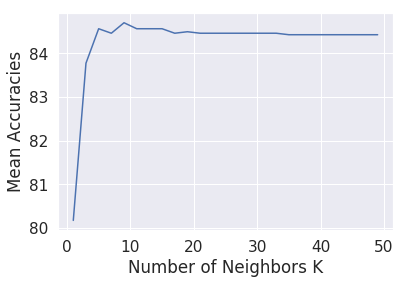

time taken: 21.356317281723022 seconds


In [20]:
start_time = time.time()
optimal_k,accuracy,acc_scores=func_bruteforce(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## Test-accuracy on tf-idf

In [21]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 83.933333%


## confusion matrix on tf-idf (brute)

accuracy we got: 83.93333333333334
precision value : 0.839622641509434
recall : 0.9975980784627703
F1-SCORE : 0.9118185144529821
     [TN       FP] 
      [FN      TP]
None


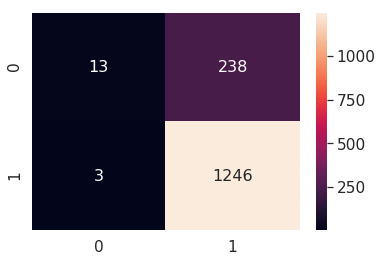

In [22]:
print(confuse_matrix(optimal_k,pred,y_test))

## KD-Tree on tf-idf

optimal k : {'n_neighbors': 5}  with accuracy : 84.6655231560892

list of accuracies : [80.92624357 84.08233276 84.66552316 84.5626072  84.52830189 84.59691252
 84.52830189 84.49399657 84.49399657 84.45969125 84.49399657 84.45969125
 84.45969125 84.45969125 84.45969125 84.45969125 84.45969125 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


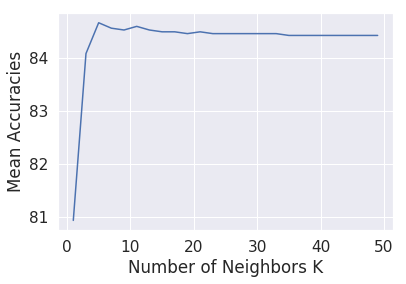

time taken: 348.4332015514374 seconds


In [23]:
start_time = time.time()
train_svd,test_svd=TSVD(X_train,X_test) # passing our vectorized array to TSVD function
optimal_k,accuracy,acc_scores=func_kdtree(train_svd,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-acc on tf-idf(kd-tree)

In [24]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],train_svd,test_svd)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 5 is 82.666667%


## confusion-matrix on tf-idf(kd-tree)

accuracy we got: 82.66666666666667
precision value : 0.8338960162052668
recall : 0.988791032826261
F1-SCORE : 0.9047619047619048
     [TN       FP] 
      [FN      TP]
None


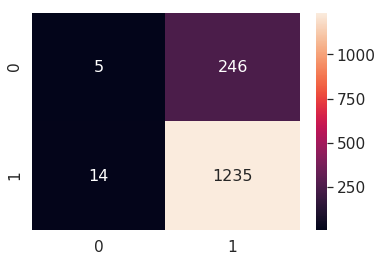

In [25]:
print(confuse_matrix(optimal_k,pred,y_test))

## Word-2-Vector Model

In [26]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[] # list used to store the words seperated with commas for building our w2vec model 
for sent in df1['CleanedText'].values:
    list_of_sent.append(sent.split())# split acc. to space (default split)

In [27]:
print(df1['CleanedText'].values[0]) # actual text contained in cleaned text
print("*****************************************************************")
print(list_of_sent[0]) # seperated words

night big fan cartoon shown decid watch also tri see winona ryder movi know well known fact like see danc end movi hey funni apart hilari film like much thing wrong short mayb special efect bit hey older
*****************************************************************
['night', 'big', 'fan', 'cartoon', 'shown', 'decid', 'watch', 'also', 'tri', 'see', 'winona', 'ryder', 'movi', 'know', 'well', 'known', 'fact', 'like', 'see', 'danc', 'end', 'movi', 'hey', 'funni', 'apart', 'hilari', 'film', 'like', 'much', 'thing', 'wrong', 'short', 'mayb', 'special', 'efect', 'bit', 'hey', 'older']


In [28]:
# min_count = 1 considers all the words
w2v_model=Word2Vec(list_of_sent,min_count=1,size=300, workers=4)

In [29]:
w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 1 time ",len(w2v_words))
# # print("sample words ", w2v_words[0:NumOfWords])


In [30]:
w2v_model.wv.most_similar('friend')

[('away', 0.9998213052749634),
 ('special', 0.9997816681861877),
 ('sure', 0.9997462034225464),
 ('plan', 0.9997340440750122),
 ('probabl', 0.999731183052063),
 ('offic', 0.9997212290763855),
 ('sardin', 0.9997199773788452),
 ('experi', 0.9997192621231079),
 ('given', 0.9997184872627258),
 ('trap', 0.9997171759605408)]

In [31]:
w2v_model.wv.most_similar('milk')

[('add', 0.9994142055511475),
 ('coconut', 0.999239981174469),
 ('hot', 0.9991186857223511),
 ('ad', 0.998521089553833),
 ('bitter', 0.9979516267776489),
 ('mix', 0.9979391694068909),
 ('dark', 0.9978399276733398),
 ('sugar', 0.9977403879165649),
 ('strong', 0.9967581033706665),
 ('ice', 0.9966917037963867)]

## Avg- word 2 vector

In [32]:
# average Word2Vec
# compute average word2vec for each review.
final_list=[]; # list which stores avg-w2v for each review
for sent in list_of_sent: # iterating through each review
    sent_vec = np.zeros(300) # intializing an array to 300 dimensions to store all avg-w2vec in document
    count=0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words: 
            vec = w2v_model.wv[word] # converting word to vector at this instance
            sent_vec+= vec # adding each vector upto our length of document
            count+=1 # increment-word count
    if count!=0: # base condition that satisfies for each document(min count of words >=1)
        sent_vec/=count  #avg of all word-vectors
    final_list.append(sent_vec) # appending avg-w2v to our list
print(len(final_list))
print(len(final_list[0]))
print(final_list[0])

5000
300
[-0.01164844 -0.16398207 -0.1598202  -0.20830556  0.1930184  -0.00523259
  0.12709514  0.1379925   0.31362519 -0.12860666 -0.12486024  0.11189036
 -0.19413995 -0.14901359  0.00896853 -0.05037179 -0.11900527  0.03789675
 -0.08068039  0.30614107  0.33141025  0.1074885  -0.14101324  0.032429
  0.21435868  0.07603103  0.31960051 -0.01160748  0.01687335  0.13656699
  0.06671033  0.06207677  0.16056856 -0.08613736  0.2423953   0.0169799
  0.28325437  0.02052751 -0.16824489 -0.06350347 -0.00683602  0.28731411
  0.06820311  0.1762026  -0.00340028  0.1096158   0.12631391 -0.17586311
  0.30316582 -0.16262445 -0.00711274  0.18104894 -0.20172886 -0.38927122
  0.21718782 -0.02526711  0.04045336 -0.29768907  0.02897178  0.03854182
  0.40598411  0.09192314  0.24544751  0.32983695 -0.01685455 -0.04935611
  0.00132356 -0.24400696  0.03461177 -0.27146973  0.20008281 -0.14294173
 -0.03765911  0.00714741  0.00833894  0.07264583  0.00798375  0.03662911
 -0.0110697  -0.10806979  0.07848909  0.10159

In [33]:
np.isnan(final_list).any() # checking if any undefined values(NaN) present in our data

False

In [34]:
# final_list_norm=preprocessing.normalize(final_list)
X_train,X_test,y_train,y_test=train_test_split(final_list,df1['Score'].values,test_size=0.3,shuffle=False)
# time basis split, hence, shuffle =false
#X_train[0]
final_list=np.asarray(final_list)

## brute-force on avg- w2 vec

optimal k : {'n_neighbors': 17}  with accuracy : 84.4253859348199

list of accuracies : [76.432247   81.23499142 83.25900515 83.97941681 84.21955403 84.28816467
 84.28816467 84.39108062 84.42538593 84.39108062 84.3567753  84.39108062
 84.39108062 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


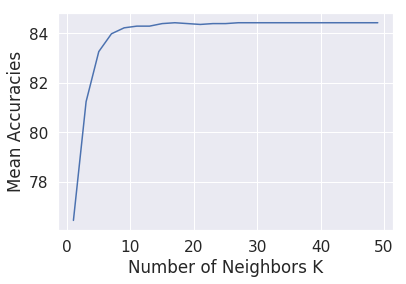

time taken: 40.699716567993164 seconds


In [35]:
start_time = time.time()
optimal_k,accuracy,acc_scores=func_bruteforce(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-accuracy on avg-w2v(brute)

In [36]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 83.266667%


## confusion-matrix on avg-w2v(brute)

accuracy we got: 83.26666666666667
precision value : 0.8326666666666667
recall : 1.0
F1-SCORE : 0.9086940705711167
     [TN       FP] 
      [FN      TP]
None


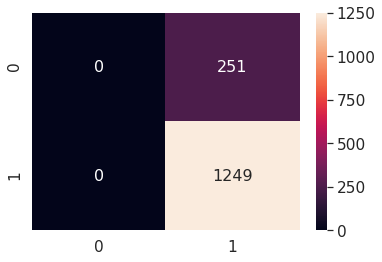

In [37]:
print(confuse_matrix(optimal_k,pred,y_test))

## K-D tree on avg-w2vec

optimal k : {'n_neighbors': 17}  with accuracy : 84.4253859348199

list of accuracies : [76.432247   81.23499142 83.25900515 83.97941681 84.21955403 84.28816467
 84.28816467 84.39108062 84.42538593 84.39108062 84.3567753  84.39108062
 84.39108062 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


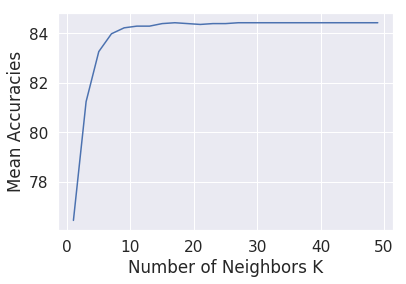

time taken: 70.69144010543823 seconds


In [38]:
start_time = time.time()
# AS AVG-W2V IS dense matrix , we no need to apply truncated SVD on this model
optimal_k,accuracy,acc_scores=func_kdtree(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-acc on avg w2v(KD)

In [39]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 17 is 83.266667%


## confusion-matrix on avg-w2v(KD-TREE)

accuracy we got: 83.26666666666667
precision value : 0.8326666666666667
recall : 1.0
F1-SCORE : 0.9086940705711167
     [TN       FP] 
      [FN      TP]
None


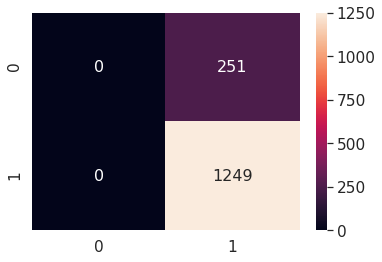

In [40]:
print(confuse_matrix(optimal_k,pred,y_test))

# TF-IDF WEIGHTED W2VEC

Take weighted sum of the vectors divided by the sum of all the tfidf's
------------->(tfidf(word) x w2v(word))/sum(tfidf's)

----------->another type of vectorization technique to convert sentence into vector notation

In [41]:
# X_train,X_test,y_train,y_test=train_test_split(df1['CleanedText'],df1['Score'].values,test_size=0.3,shuffle=False)
final_tf_idf=tfidf.fit_transform(df1['CleanedText'].values)
print(final_tf_idf.shape)# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
# TF-IDF weighted Word2Vec
features= tfidf.get_feature_names() # tfidf words/col-names
tfidf_final_list=[]; # the tfidf-w2v for each sentence/review is stored in this list
rows=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec=np.zeros(300) # intializing an array to 300 dimensions to store all tf-idf-w2vec in document
    weight_sum=0; # num of words with a valid vector in the sentence/review
    for word in sent: # iterating through each review
        if word in w2v_words:
            vec=w2v_model.wv[word] # converting word to vector at this instance
            tf_idf=final_tf_idf[rows,features.index(word)] # obtain the tf_idfidf of a word in a sentence/review
            sent_vec+=(vec*tf_idf) #multiplying tf-idf value of word with w2v vector of that word
            weight_sum+=tf_idf # summating tf_idf value of every word
    if weight_sum!= 0: # base condition that satisfies for each document(min weighted sum >=1)
        sent_vec/= weight_sum # for each document ,this step converts sentence to tf-idf-w2v format by dividing TF-IDF sentence vectors with sum of all tf-idf's
    tfidf_final_list.append(sent_vec)
    rows+=1

(5000, 13166)


In [42]:
type(final_tf_idf) # 

scipy.sparse.csr.csr_matrix

In [43]:
tfidf_final_list=np.asarray(tfidf_final_list)
X_train, X_test, y_train, y_test=train_test_split(tfidf_final_list,df1['Score'].values,test_size=0.3,shuffle=False)
tfidf_final_list.shape

(5000, 300)

In [44]:
np.isnan(tfidf_final_list).any() # checking if any undefined values(NaN) present in our data

False

## brute-force on TF-IDF w2v 

optimal k : {'n_neighbors': 15}  with accuracy : 84.4253859348199

list of accuracies : [77.11835334 81.09777015 83.3619211  83.97941681 84.3567753  84.28816467
 84.3567753  84.42538593 84.42538593 84.39108062 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


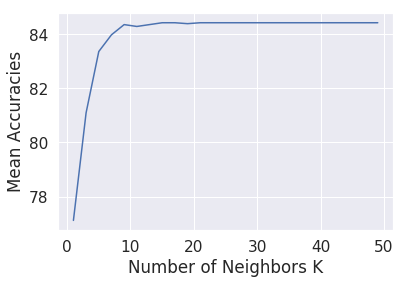

time taken: 26.69974637031555 seconds


In [45]:
start_time = time.time()
optimal_k,accuracy,acc_scores=func_bruteforce(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## Test-acc on tf-idf w2v (brute)

In [46]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 83.066667%


## confusion matrix on tf-idf w2v(brute)

accuracy we got: 83.06666666666666
precision value : 0.8323313293253173
recall : 0.9975980784627703
F1-SCORE : 0.9075018208302986
     [TN       FP] 
      [FN      TP]
None


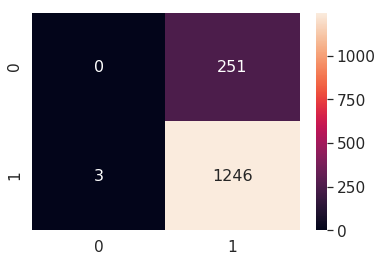

In [47]:
print(confuse_matrix(optimal_k,pred,y_test))

## kd-tree on tf-idf w2v (brute)

optimal k : {'n_neighbors': 15}  with accuracy : 84.4253859348199

list of accuracies : [77.11835334 81.09777015 83.3619211  83.97941681 84.3567753  84.28816467
 84.3567753  84.42538593 84.42538593 84.39108062 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


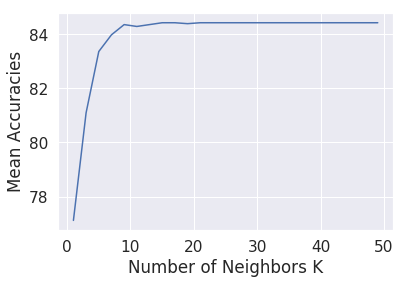

time taken: 52.86696982383728 seconds


In [48]:
start_time = time.time()
# AS tf-idf w2v IS dense matrix , we no need to apply truncated SVD on this model
optimal_k,accuracy,acc_scores=func_kdtree(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-acc on tfidf w2v (kd-tree)

In [49]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 15 is 83.066667%


## confusion-matrix on tfidf-w2v (kd-tree)

accuracy we got: 83.06666666666666
precision value : 0.8323313293253173
recall : 0.9975980784627703
F1-SCORE : 0.9075018208302986
     [TN       FP] 
      [FN      TP]
None


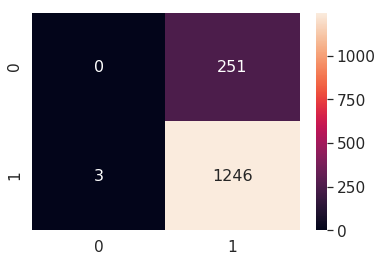

In [50]:
print(confuse_matrix(optimal_k,pred,y_test))

## BAG - OF - WORDS (Bi-grams)

we've done vectorization on uni-grams using bag-of-words.Bi-gram model will take all unique sets of adjacent two words and then count their occurrences to assign frequency

In [52]:
X_train,X_test,y_train,y_test = train_test_split(df1['CleanedText'].values,df1['Score'].values,test_size=0.3,shuffle=False) # splitting into test and train
# we are not using random state because we've already split  based on time
c_vector=CountVectorizer(ngram_range=(1,2)) # intialising bow vectorizer of bi-grams
X_train=c_vector.fit_transform(X_train) # feature extraction of X_train
X_train=preprocessing.normalize(X_train) # normalise data
print("Train Data Size: ",X_train.shape)
X_test=c_vector.transform(X_test) # feature extraction of X_test
X_test=preprocessing.normalize(X_test) # normalise data
print("Test Data Size: ",X_test.shape)

Train Data Size:  (3500, 107862)
Test Data Size:  (1500, 107862)


## Brute-force algorithm(bi-grams-BOW)

optimal k : {'n_neighbors': 5}  with accuracy : 84.6655231560892

list of accuracies : [80.24013722 84.11663808 84.66552316 84.66552316 84.59691252 84.5626072
 84.5626072  84.49399657 84.45969125 84.45969125 84.42538593 84.45969125
 84.45969125 84.45969125 84.45969125 84.45969125 84.45969125 84.45969125
 84.45969125 84.45969125 84.45969125 84.45969125 84.42538593 84.42538593
 84.42538593]


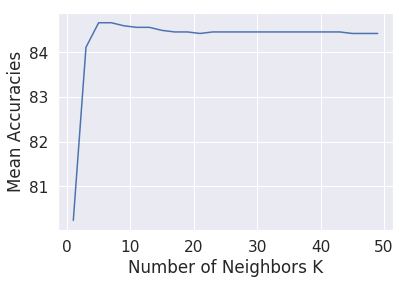

time taken: 1945.3550109863281 seconds


In [53]:
start_time = time.time()
optimal_k,accuracy,acc_scores=func_bruteforce(X_train,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-acc on bruteforce(bi-gram)

In [54]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],X_train,X_test)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 5 is 84.466667%


## confusion matrix (bi-grams-bruteforce)

accuracy we got: 84.46666666666667
precision value : 0.8522884882108183
recall : 0.9839871897518014
F1-SCORE : 0.9134150873281308
     [TN       FP] 
      [FN      TP]
None


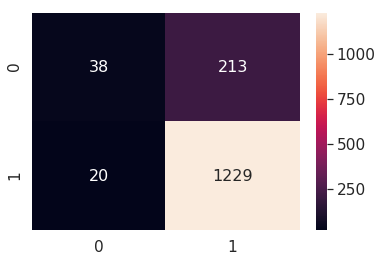

In [56]:
print(confuse_matrix(optimal_k,pred,y_test))

## KD-TREE(bi-gram)

optimal k : {'n_neighbors': 9}  with accuracy : 84.52830188679246

list of accuracies : [79.31389365 82.5728988  83.94511149 84.32246998 84.52830189 84.42538593
 84.52830189 84.42538593 84.45969125 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593 84.42538593
 84.42538593]


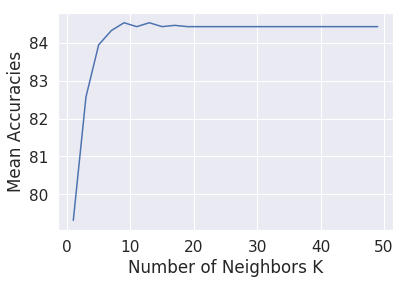

time taken: 418.3834536075592 seconds


In [58]:
start_time = time.time()
train_svd,test_svd=TSVD(X_train,X_test) # passing our vectorized array to TSVD function
optimal_k,accuracy,acc_scores=func_kdtree(train_svd,y_train)
print('optimal k :',optimal_k,' with accuracy :',accuracy)
print('\nlist of accuracies :',acc_scores)
plt.plot(list(range(1,50,2)),acc_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Mean Accuracies')
plt.show()
print("time taken: %s seconds" %(time.time()-start_time))

## test-acc on kd-tree(bi-grams)

In [59]:
optimal_k,acc,pred=test_acc(optimal_k['n_neighbors'],train_svd,test_svd)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 82.933333%


## conf-matrix(kd-tree) on bi-grams

accuracy we got: 82.93333333333334
precision value : 0.8321070234113712
recall : 0.9959967974379503
F1-SCORE : 0.9067055393586007
     [TN       FP] 
      [FN      TP]
None


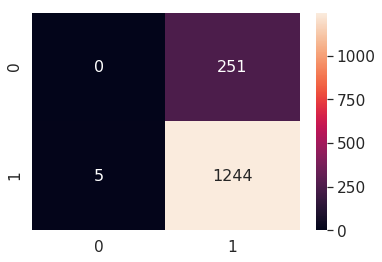

In [60]:
print(confuse_matrix(optimal_k,pred,y_test))

# observations(Accuracies on each vectorization):

### CONCLUSIONS

----->As observed, Highest accuracy was achieved by bag-of-words(using bi-grams), 84.46%

----->For Avg-w2v and TF-IDF w2v , BRUTE-FORCE and KD-TREE yielding similar accuracies

----->CV accuracy and test-accuracy doesn't changes much for same algorithm

----->taking a lot of time for training(with truncated svd, it takes much more time to train)

